**Overview**

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

**Dataset** 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a score >= 7 out of 10. Thus reviews with
more neutral ratings are not included in the train/test sets. In the
unsupervised set, reviews of any rating are included and there are an
even number of reviews > 5 and <= 5.

**Text Classification using RNN**

We are using the IMDB large movie review dataset from the tenserflow dataset.It is a binary classification dataset—all the reviews have either a positive(1) or negative(0) sentiment.

### Importing all the necessary libraries and packages

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

## Setup input pipeline

### Loading the in-built IMDB Movie Dataset from the tensorflow library

In [ ]:
movie_dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)

In [ ]:
movie_dataset

{'train': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'test': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'unsupervised': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

### Splitting the dataset into train and test

In [ ]:
train_movie_dataset = movie_dataset['train']
test_movie_dataset  = movie_dataset['test']


### Checking the type specification of an element of this dataset.

In [ ]:
train_movie_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Displaying the first record in training set.
### Here, label can be 0:Positive or 1:Negative

In [ ]:
for example, label in train_movie_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


The BUFFER_SIZE define a random first element between the size of BUFFER_SIZE. After choose this random one, the next numbers will follow the size of BUFFER_SIZE

BATCH_SIZE is the number of samples we send to the model at a time.

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

Now time to Prefetching overlaps the preprocessing and model execution with buffer of a training step.
Then also excecute the test model with prefetching model overlap preprocessing.

In [ ]:
train_movie_dataset = train_movie_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_movie_dataset = test_movie_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Let's time to observe 3 movie review based on positive and negative labels. 

In [ ]:
for example, label in train_movie_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"here, let me wave my hands over the keyboard, i'll tell you what salad she's going to order. over and over, works like a charm: he's such a genius, omg how does he do it? my bullshit detector freaks if i even pass this show when i'm scanning channels, I have to be very careful (these days it's useful far too often, so I don't need it getting broken on idiotic crap like this...careful with that remote!). is this supposed to be some fascist propaganda to make people believe in some invisible realm of uberman control and mastery? or what? why does it exist??<br /><br />this is THE most inane show, completely unbelievable and contrived, and I cannot understand why it's still on the air. so may geeks give SO much better shows such a hard time (Sarah Connor Chronicles, True Blood), but give this nonsensical drivel a pass. shows like Firefly (if there were any like that) fall away after a season, but mindless stuff like this that makes zero logical sense just keeps marching on. yec

In the result we got 3 of them result as 0,0,0 which denoted that the negative review.

### Create the text encoder
The processing of each sequence is undertaken by the following steps:

1. Standardize the sequence by removing punctuation and converting it to lowercase.

2. Splitting a sentence into individual words

3. Recombining words into tokens

4. Associating a unique integer value to each token

5. Converting each sentence using the index into a vector of integers

In [ ]:
VOCAB_SIZE = 1000   #Here, we are 
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_movie_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[132, 372,  70, ...,   0,   0,   0],
       [ 11, 548,   7, ...,   0,   0,   0],
       [869,  11,  18, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"here, let me wave my hands over the keyboard, i'll tell you what salad she's going to order. over and over, works like a charm: he's such a genius, omg how does he do it? my bullshit detector freaks if i even pass this show when i'm scanning channels, I have to be very careful (these days it's useful far too often, so I don't need it getting broken on idiotic crap like this...careful with that remote!). is this supposed to be some fascist propaganda to make people believe in some invisible realm of uberman control and mastery? or what? why does it exist??<br /><br />this is THE most inane show, completely unbelievable and contrived, and I cannot understand why it's still on the air. so may geeks give SO much better shows such a hard time (Sarah Connor Chronicles, True Blood), but give this nonsensical drivel a pass. shows like Firefly (if there were any like that) fall away after a season, but mindless stuff like this that makes zero logical sense just keeps marching on. y

As you can see from the above result, we got some "unknown" tokens as [UNK] which we can see in round-trip section.

### Create the model

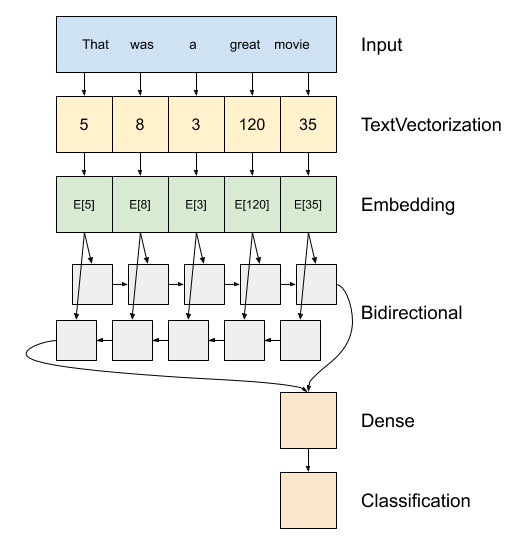

• Let's take a reference from the above diagram to build a model.

• We will build a model with the help of tf.keras.Sequential.

• Here the first layer is the encoder, which converts the text to a sequence of token indices.

• After the encoder 2nd layer is an embedding layer that stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training words with similar meanings often have similar vectors.

• RNN processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

• A bidirectional wrapper can also be used with an RNN layer. This layer propagates the input forward and backward through the RNN layer and then concatenates the final output.

• The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed through every timestep to affect the output.

• After the RNN has converted the sequence to a single vector the two layers are. Dense does some final processing and converts from this vector representation to a single logit as the classification output.



## Now time to build the model by considering above steps

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Now that the length of every sample is the same, the model has to be alerted that some of the data is padding  (where padding is a unique type of masking that places the masked steps at the beginning or conclusion of a sequence)and should be disregarded. This system uses masking.



In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding with the help of predict function

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[0.00115585]


In [ ]:
# predict on a sample text with 2000 padding with the help of predict function 

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 463ms/step
[0.00115585]


In this model we got same results for both type of situation with and without padding. 

The purpose of loss functions is to compute the quantity that a model should seek to minimize during training.

BinaryCrossentropy computes the cross-entropy loss between true labels and predicted labels.

Use this cross-entropy loss for binary (0 or 1) classification applications. 

With the help of compile method, we will compile our model.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the model

In [ ]:
history = model.fit(train_movie_dataset, epochs=10,
                    validation_data=test_movie_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 814s 2s/step - loss: 0.6430 - accuracy: 0.5669 - val_loss: 0.5013 - val_accuracy: 0.7474
Epoch 2/10
391/391 [==============================] - 832s 2s/step - loss: 0.4524 - accuracy: 0.7874 - val_loss: 0.4151 - val_accuracy: 0.8089
Epoch 3/10
391/391 [==============================] - 790s 2s/step - loss: 0.3680 - accuracy: 0.8397 - val_loss: 0.3612 - val_accuracy: 0.8448
Epoch 4/10
391/391 [==============================] - 791s 2s/step - loss: 0.3350 - accuracy: 0.8568 - val_loss: 0.3370 - val_accuracy: 0.8516
Epoch 5/10
391/391 [==============================] - 791s 2s/step - loss: 0.3221 - accuracy: 0.8600 - val_loss: 0.3286 - val_accuracy: 0.8604
Epoch 6/10
391/391 [==============================] - 823s 2s/step - loss: 0.3114 - accuracy: 0.8674 - val_loss: 0.3245 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 799s 2s/step - loss: 0.3040 - accuracy: 0.8705 - val_loss: 0.3591 - val_accuracy: 0.8552

In [ ]:
test_loss, test_acc = model.evaluate(test_movie_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 189s 482ms/step - loss: 0.3194 - accuracy: 0.8641
Test Loss: 0.3194221556186676
Test Accuracy: 0.8641200065612793


So, at last we got accuracy of **86.41%** which indicates the model is performing good with loss is **31%**

Now time to visualize the accuracy and loss we got from our model with the help of line graph by using matplotlib library.

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6603117644786834)

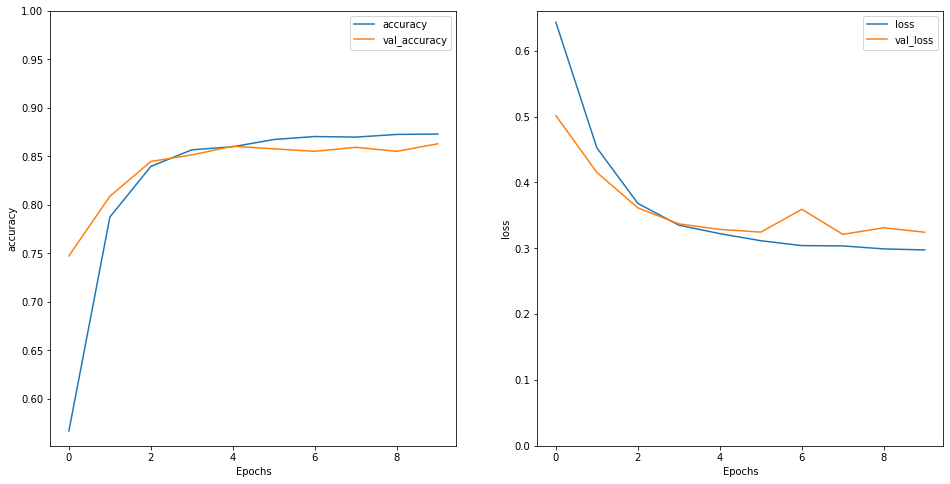

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

**Conclusion**

• Our model got an accuracy of 86%.

• Here, in RNN, we can tune the parameters and increase the epochs in order to improve the accuracy and reduce the loss. 

• But, on the other hand each epoch took 15-16 mins to run.

• Therefore, when we increase the epochs it also takes more time to run the model.


**References**:

1.   https://www.tensorflow.org/text/tutorials/text_classification_rnn
2.   https://www.tensorflow.org/



